# Test on simulated data

This notebook illustrates a simple validation of the implemented shakemap algorithm from Worden et al. (2018). Note that since v1.2, the preferred algorithm is from Engler et al. (2022). The differences in the results from both methods are small, but the latter algorithm is probabilistically more sound. See also the theoretical background. 

We again use the rupture and the seismic network from the 2023 earthquake at the border of Turkey and Syria. For that purpose, ground-motion intensity measures are simulated at the seismic network stations. Then, we use the implemented algorithm to estimate the between-event and within-event residuals. Finally the estimated values are compared to the "true" values used in the simulation. 

**References**

Engler T., Worden B., Thompson E., and Jaiswal K. (2022): Partitioning Ground Motion Uncertainty When Conditioned on Station Data. Bulletin of the Seismological Society of America. doi: : [10.1785/0120210177](https://doi.org/10.1785/0120210177)

Worden B., Thompson E., Baker J., Bradley B., Luco N., and Wald D. (2018): "Spatial and Spectral Interpolation of Ground-Motion Intensity Measure Observations", Bulletin of the Seismological Society of America, doi: [10.1785/0120170201](https://doi.org/10.1785/0120170201) 

In [1]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import openquake.hazardlib as oq
plt.style.use('ggplot')
path_data = 'data' + os.sep

In [2]:
# --------------
# Import rupture
# --------------

from utils import get_planarsurface
Point = oq.geo.point.Point
BaseRupture = oq.source.rupture.BaseRupture

option_rupture = 'shakemap' # 'shakemap' or 'finitefault' as stated above

f = open(path_data + 'rupture.json')
rup_temp = json.load(f)
f.close()

if option_rupture == 'shakemap':
    rupture_surface = get_planarsurface(rup_temp['features'][0]['geometry'])
elif option_rupture == 'finitefault':
    from utils import get_finite_fault
    rupture_surface = get_planarsurface(get_finite_fault())
rup_temp = rup_temp['metadata']
rupture = BaseRupture(mag = rup_temp['mag'], rake = rup_temp['rake'], 
                    tectonic_region_type = 'Active Shallow Crust', 
                    hypocenter = Point(longitude = rup_temp['lon'], 
                                        latitude = rup_temp['lat'],
                                        depth = rup_temp['depth']),
                    surface = rupture_surface)

# --------------
# Import station data
# --------------

from utils import read_stationlist

f = open(path_data + 'stationlist.json')
stations_temp = json.load(f)
stations_temp = stations_temp['features']
f.close()

dfstations = read_stationlist(stations_temp)

# --------------
# Specify modules
# --------------

from modules.shakemap import Stations, GMM, Sites
from modules.spatialcorrelation import (HeresiMiranda2019, 
                                        EspositoIervolino2012esm,
                                        BodenmannEtAl2022)

# Specify considered intensity measure: 'PGA', 'SA(0.3)', 'SA(1.0)', 'SA(3.0)'
im_string = 'SA(1.0)'

# Specify Ground-Motion model
gmm = GMM(oq.gsim.cauzzi_2014.CauzziEtAl2014(), im_string)
# gmm = GMM(oq.gsim.akkar_2014.AkkarEtAlRjb2014(), im_string)

# Specify Correlation model
scm = EspositoIervolino2012esm(im_string)
# scm = HeresiMiranda2019(im_string)
# scm = BodenmannEtAl2022(im_string, rupture)

**Simulate intensity measures at locations of seismic stations**

In [3]:
sites = Sites(dfstations)
gmm_results = gmm.get_mean_and_std(rupture, sites)
corr_mat = scm.get_correlation_matrix(sites, full_cov=True)

rng = np.random.default_rng(91)

mean = gmm_results['mu_logIM']
deltaW_sim = (rng.multivariate_normal(np.zeros_like(mean), corr_mat, 1).squeeze() *
               np.mean(gmm_results['phi']) )
deltaB_sim = rng.normal() * np.mean(gmm_results['tau'])
sim = mean + deltaW_sim + deltaB_sim

# Store values in dataframe
dfstations_sim = dfstations.copy()
dfstations_sim['sa(1.0)_E'] = np.exp(sim)
dfstations_sim['sa(1.0)_N'] = np.exp(sim)

**Estimate residuals**

In [4]:
stations = Stations(dfstations_sim, im_string)
from modules.shakemap import Shakemap_WordenEtAl2018
shakemap = Shakemap_WordenEtAl2018(Rupture = rupture, 
                    Stations = stations,
                    GMM = gmm,
                    SCM = scm)
deltaW_pred = shakemap.residuals.squeeze()
deltaB_pred_mean = shakemap.xiB.squeeze()
deltaB_pred_std = np.sqrt(shakemap.psiBsq.squeeze())

**Between-event residual**

Based on the recordings, the algorithm estimates the mean and remaining variance of the between-event residual. The figures below compare the estimated distribution to the "true" value used in the simulation.

"True" value: 0.056
{'mean': 0.056, '5,95% quantiles': (-0.022, 0.134)}


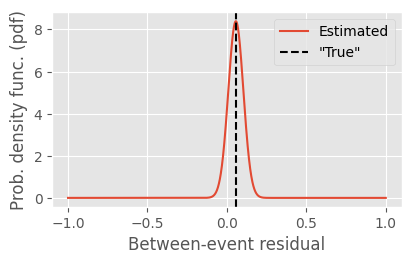

In [6]:
from scipy.stats import norm
print('"True" value: ' + str(round(deltaB_sim, 3)))
quantiles = norm.ppf([0.05, 0.95], loc=deltaB_pred_mean, scale=deltaB_pred_std)
res_metrics = {'mean': np.round(deltaB_pred_mean,3), 
               '5,95% quantiles': tuple(np.round(quantiles,3))}
print(res_metrics)

x = np.linspace(-1,1,2000)
fig, ax = plt.subplots(figsize=(4, 2.5), constrained_layout=True)
ax.plot(x, norm.pdf(x, loc=deltaB_pred_mean, scale=deltaB_pred_std), label='Estimated')
ax.axvline(deltaB_sim, color='black', ls='--', label='"True"')
ax.legend()
ax.set_xlabel('Between-event residual')
ax.set_ylabel('Prob. density func. (pdf)')
plt.show()


**Within-event residual**

The predicted mean between-event residual is used to compute the remaining within-event residual at each station. The following plot compares the computed values with the "true" simulated values.

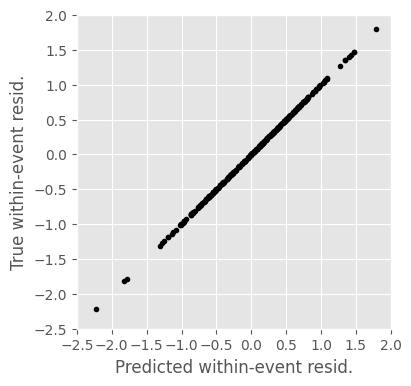

In [7]:
fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True)
ax.plot(deltaW_pred, deltaW_sim, ls='none', marker='.', color='black')
ax.set_aspect('equal')
ax.set_xticks(ax.get_yticks())
ax.set_ylim(ax.get_xlim())
ax.set_xlabel('Predicted within-event resid.')
ax.set_ylabel('True within-event resid.')
plt.show()